# Lista 3

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy import sparse
import scipy as scp
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### HELPERS

In [4]:
# Função para plotar os curvas de nível constante de temperatura

def PlotaTemperature(n,m,T):
    x = np.arange(0, n, 1)
    y = np.arange(0, m, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(T)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of temperature')
    im = ax.contourf(X, Y, Z.T, 20, cmap='jet')
    im2 = ax.contour(X, Y, Z.T, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()

## EXERCÍCIO 1

Rodas os Códigos do método Jacobi e Gauss-Seidel e fazer uma tabela para calcular o número de iterações necessárias para atingir a convergência numa tolerância de $10^{-5}$ e $10^{-8}$. Considerando as discretizações com N = 11, N = 21 e N = 41. Tirar conclusões

In [5]:
def Jacobi(N, tolerance):
    Told = np.zeros(shape=(N,N))
    Tnew = np.zeros(shape=(N,N))

    # Temperaturas nas bordas
    Told[0, :] = 0.0 # TL
    Told[N-1,:] = 0.0 # TR
    Told[:, 0] = 0.0 # TB
    Told[:,N-1] = 20.0 # TT

    # Loop de iteracoes
    Nmax = 10000
    Tnew = Told.copy()

    for iter in range(Nmax):
        Tnew[1:N-1,1:N-1] = 0.25*(Told[2:N,1:N-1] + Told[0:N-2,1:N-1] + Told[1:N-1,2:N] + Told[1:N-1,0:N-2]) # SOMA DOS VIZINHOS
        error = np.linalg.norm(Tnew-Told)
        if(error < tolerance):
            break
            #print("Converged in %d iterations\n" %(iter))
            

        Told = Tnew.copy()
    return(iter)

In [6]:
def Gauss_Seidel(N, tolerance):
    # Metodo de Gauss-Seidel

    Told = np.zeros(shape=(N,N))
    Tnew = np.zeros(shape=(N,N))

    # Temperaturas nas bordas
    Told[0, :] = 0.0 # TL
    Told[N-1,:] = 0.0 # TR
    Told[:, 0] = 0.0 # TB
    Told[:,N-1] = 20.0 # TT

    # Loop de iteracoes
    Nmax = 10000
    Tnew = Told.copy()
    for iter in range(Nmax):
        for i in range(1,N-1):
            for j in range(1,N-1):
                Tnew[i,j] = 0.25*(Told[i+1,j] + Tnew[i-1,j] + Told[i,j+1] + Tnew[i,j-1])

        error = np.linalg.norm(Tnew-Told)
        if(error < tolerance):
            break 
            #print(’Converged in %d iterations\n’ %(iter))

        Told = Tnew.copy()

    return iter

In [7]:
Nvalues = [11, 21, 41]

Jacobi_5 = []
Jacobi_8 = []

GauS_5 = []
GauS_8 = []

for i in Nvalues:
    Jacobi_5.append(Jacobi(i, 10**-5))
    Jacobi_8.append(Jacobi(i, 10**-8))
    GauS_5.append(Gauss_Seidel(i, 10**-5))
    GauS_8.append(Gauss_Seidel(i, 10**-8))

In [8]:
# MONTANDO TABELA

fig = go.Figure(data=[go.Table(header=dict(values=['N', 'Jacobi (10^{-5})','Jacobi (10^{-8})', 'Gauss (10^{-5})','Gauss (10^{-8})']),
                 cells=dict(values=[Nvalues,Jacobi_5,Jacobi_8,GauS_5,GauS_8 ]))
                     ])
fig.update_layout(width=572,height=90,margin_b=1,margin_l=1,margin_r=1,margin_t=1)
fig.show()

## EXERCÍCIO 2

Implementar o método iterativo geral e testar para os casos do exercício 1. Comparar os resultados.

In [4]:
# MONTANDO MATRIZ

def ij2n (i, j, N):
    return i + j*N

def MatAssembly(N):
    nunk = N*N
    A = np.zeros(shape=(nunk,nunk))
    for i in range(1,N-1):
        for j in range(1,N-1):
            Ic = ij2n(i, j, N)      # PONTO CENTRAL
            Ie = ij2n(i+1, j, N)    # DIREITA
            Iw = ij2n(i-1, j, N)    # ESQUERDA
            In = ij2n(i, j+1, N)    # BAIXO
            Is = ij2n(i, j-1, N)    # CIMA

            A[Ic,[Ic,Ie,Iw,In,Is]] = [4.0, -1.0, -1.0, -1.0, -1.0]
    return A

In [10]:
# CALCULA TEMPERATURA NAS BORDAS

def BuildSystem(N, TL, TR, TB, TT):
    A = MatAssembly(N)
    Atilde = A.copy()

    nunk = N**2
    b = np.zeros(shape=(nunk,1)) # right-hand-side

    k = np.array(range(0,N)) # Auxiliary array
    Iden = np.identity(nunk) # Auxiliary matrix

    Ic = ij2n(0,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL # Tleft

    Ic = ij2n(N-1,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR # Tright

    Ic = ij2n(k,0,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB # Tbottom

    Ic = ij2n(k,N-1,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT # Ttop

    return Atilde, b

In [11]:
# METODO ITERATIVO GERAL

def Metodo_Iterativo_Geral (tolerance,max_iter,N,method):
    Atilde,b = BuildSystem(N,0,0,0,20)


    # ENCONTRANDO M DE ACORDO COM MÉTODO DE ESCOLHA

    if(method=='Jacobi'):
        M = np.diag(np.diagonal(Atilde))
    elif(method=='Gauss'):
        M = np.triu(Atilde)

    
    xold = np.zeros_like(b)
    res = (Atilde@xold)-b                   # CALCULANDO RESIDUAL


    for iter in range (max_iter):

        if(np.linalg.norm(res)<tolerance):  # PARA SE RESIDUAL PASSAR DA TOLERANCIA
            break

        beta = 1                            # BETA CONSNTATE
        d=np.linalg.solve(M,-res)           # AVANÇANDO D 
        xnew=(xold+(beta*d))                # AVANÇANDO X

        res=((Atilde@xnew)-b)               # CALCULANDO RESIDUAL
        xold=xnew
    
    return iter+1                           # RETORNA ITER

In [12]:
max_iter = 10000
iterGauss = []
iterJacob = []
n_Values = [11,21, 41]

for i in n_Values:
    iterGauss.append(Metodo_Iterativo_Geral(10**-8, max_iter, i, 'Gauss'))
    iterJacob.append(Metodo_Iterativo_Geral(10**-8, max_iter, i, 'Jacobi'))


fig = go.Figure(data=[go.Table(header=dict(values=['N','Gauss (e-8)','Jacobi (e-8)']),
                 cells=dict(values=[n_Values,iterGauss,iterJacob]))
                     ])
fig.update_layout(width=572,height=90,margin_b=1,margin_l=1,margin_r=1,margin_t=1)
fig.show()

## EXERCÍCIO 3

Modificar a função que fixa as condições de contorno de forma tal que se mantenha a simetria de matriz. Testar aplicando o método iterativo geral usado anteriormente.

In [13]:
# CONSTROI MATRIZ SIMÉTRICA

def BuildSystemSim(N, TL, TR, TB, TT):
    nunk = N**2
    A = MatAssembly(N)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    Ic = ij2n(0,k,N) # TL
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TL 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL
    Atilde[:,Ic] = Iden[:,Ic]


    Ic = ij2n(N-1,k,N) #TR
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TR 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR
    Atilde[:,Ic] = Iden[:,Ic]


    Ic = ij2n(k,0,N) #TB
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TB 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,N-1,N) #TT
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TT
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT
    Atilde[:,Ic] = Iden[:,Ic]
    
    return Atilde, b


In [14]:
def Metodo_Iterativo_Geral_Simetrico (tolerance,max_iter,N,method):
    Atilde,b = BuildSystemSim(N,10,20,30,40)

    if(method=='Jacobi'):
        M = np.diag(Atilde)
    elif(method=='Gauss'):
        M = np.triu(Atilde)
        sM = sparse.csc_matrix(M)

    xold = np.zeros_like(b)

    res = (Atilde@xold)-b

    for k in range (max_iter):

        
        if(method=='Jacobi'):
            d = -res/M
        elif(method=='Gauss'):
            d=scp.sparse.linalg.spsolve(sM,-res)


        if(np.linalg.norm(res)<tolerance):
            break
        beta=1
        xnew=(xold+(beta*d))

        res=((Atilde@xnew)-b)
        xold=xnew
    return k+1

0.0


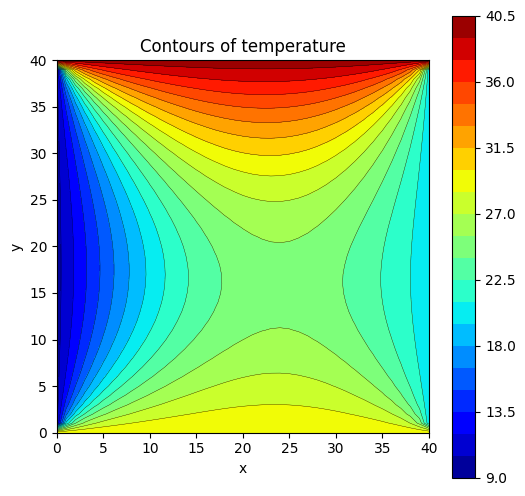

In [15]:
N = 41
Atilde, b = BuildSystemSim(N, TL=10.0, TR=20.0, TB=30.0, TT=40.0)
print(np.linalg.norm(Atilde-Atilde.T))

import scipy
from scipy.linalg import solve 

T = scipy.linalg.solve(Atilde,b)
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

In [16]:
iterGauss=[]
iterJacob=[]
iterGauss5=[]
iterJacob5=[]
#Tamanho=[11,21,41,51]
n_Values=[11,21,41]

for i in n_Values:
    iterGauss.append(Metodo_Iterativo_Geral_Simetrico(1.0e-8,10000,i,'Gauss'))
    iterJacob.append(Metodo_Iterativo_Geral_Simetrico(1.0e-8,10000,i,'Jacobi'))
    iterGauss5.append(Metodo_Iterativo_Geral_Simetrico(1.0e-5,10000,i,'Gauss'))
    iterJacob5.append(Metodo_Iterativo_Geral_Simetrico(1.0e-5,10000,i,'Jacobi'))

fig = go.Figure(data=[go.Table(header=dict(values=['N','Gauss (e-8)','Jacobi (e-8)','Gauss (e-5)','Jacobi (e-5)']),
                 cells=dict(values=[i,iterGauss,iterJacob,iterGauss5,iterJacob5]))
                     ])
fig.update_layout(width=572,height=90,margin_b=1,margin_l=1,margin_r=1,margin_t=1)
fig.show()

## EXERCÍCIO 4

In [2]:
def BuildSystemCirculo(N, TP,TC,RC):
    A = MatAssembly(N)
    Atilde = A.copy()

    nunk = N**2
    b = np.zeros(shape=(nunk,1)) # right-hand-side

    k = np.array(range(0,N)) # Auxiliary array
    Iden = np.identity(nunk) # Auxiliary matrix

    Ic = ij2n(0,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TP # Tleft

    Ic = ij2n(N-1,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TP # Tright

    Ic = ij2n(k,0,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TP # Tbottom

    Ic = ij2n(k,N-1,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TP # Ttop

    # PARTE DIFERENTE DO BUILD ANTERIOR

    h=1/(N-1)
    for i in range(N):
        xi=i*h
        for j in range(N):
            yj=j*h
            if(np.sqrt((xi-0.5)**2 + (yj-0.5)**2)<RC): #ponto cai dentro do circulo? (xi-0.5) e (yj-0.5) pois é um quadrado de 1x1
                Ic = ij2n(i,j,N)
                Atilde[Ic,:], b[Ic] = Iden[Ic,:], TC # Tbottom


    return Atilde, b

In [5]:
N=201

Atilde,b=BuildSystemCirculo(N,0,20,0.2002)
T=np.linalg.solve(Atilde,b)
Tplot=T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

## EXERCÍCIO 5

In [ ]:
import time

class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1

import inspect
class cg_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        frame = inspect.currentframe().f_back
    


In [ ]:

iterGauss=[]
iterJacob=[]
iterCG=[]
iterGMRES=[]
tGauss=[]
tJacob=[]
tCG=[]
tGMRES=[]
iterGauss5=[]
iterJacob5=[]
iterCG5=[]
iterGMRES5=[]
tGauss5=[]
tJacob5=[]
tCG5=[]
tGMRES5=[]

n_values=[11,21,41]

# Examples of direct method (escalonamento)
#print('\nMétodo direto\n')
#start_time = time.time()
#xsol_dir = scp.linalg.solve(Atilde,b)
#print("---Tempo método Direto: %s seconds ---" % (time.time() - start_time))

for i in n_values:

        start=time.time()
        iterGauss.append(Metodo_Iterativo_Geral_Simetrico(1.0e-8,10000,Tamanho[i],'Gauss'))
        tGauss.append(np.round(time.time()-start,3))

        start=time.time()
        iterJacob.append(Metodo_Iterativo_Geral_Simetrico(1.0e-8,10000,Tamanho[i],'Jacobi'))
        tJacob.append(np.round(time.time()-start,3))

        start=time.time()
        iterGauss5.append(Metodo_Iterativo_Geral_Simetrico(1.0e-5,10000,Tamanho[i],'Gauss'))
        tGauss5.append(np.round(time.time()-start,3))

        start=time.time()
        iterJacob5.append(Metodo_Iterativo_Geral_Simetrico(1.0e-5,10000,Tamanho[i],'Jacobi'))
        tJacob5.append(np.round(time.time()-start,3))

for i in range(7):
   #GMRES e CG
    Atilde, b = BuildSystemSim(Tamanho[i], TL=10.0, TR=20.0, TB=30.0, TT=40.0)

    counter = gmres_counter()
    start=time.time()
    xsol_gmres, info= linalg.gmres(Atilde, b, tol=1e-8, callback=counter)
    iterGMRES.append(counter.niter)
    tGMRES.append(np.round(time.time()-start,3))

    counter=cg_counter()
    start=time.time()
    xsol_cg, info = linalg.cg(Atilde, b, tol=1e-8, callback=counter)
    iterCG.append(counter.niter)
    tCG.append(np.round(time.time()-start,3))
        
    counter = gmres_counter()
    start=time.time()
    xsol_gmres, info= linalg.gmres(Atilde, b, tol=1e-5, callback=counter)
    iterGMRES5.append(counter.niter)
    tGMRES5.append(np.round(time.time()-start,3))

    counter=cg_counter()
    start=time.time()
    xsol_cg, info = linalg.cg(Atilde, b, tol=1e-5, callback=counter)
    iterCG5.append(counter.niter)
    tCG5.append(np.round(time.time()-start,3))

